Program to identify suspicious values in Prim master file in preparation for data cleaning.

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from datetime import datetime
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from tkinter import *
from tkinter import filedialog

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
def get_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\Masters", title = "Select PRIM master file",\
                        filetypes = (("Prim files","*.prim"),("Seco files","*.seco"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [3]:
############################################
#    MAIN PROGRAM
############################################

# Create a DT based on the structure type of the PRIM Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro
pp1 = np.dtype([
    ('P1', 'B'),('P2', 'B'),('P3', 'B'),('P4', 'B'),('P5', 'B'),('P6', 'B'),('P7', 'B'),('P8', 'B'),
    ('P9', 'B'),('P10', 'B'),('P11', 'B'),('P12', 'B')])
pp2 = np.dtype([('p1', 'f'),('p2', 'f'),('p3', 'f'),('p4', 'f')])

rectype = np.dtype([
    ('Procid',pp1),
    ('Loc','i'),
#    ('Year','i'),('Month','i'),('Day', 'i'),('Hour', 'i'),('Min', 'i'), ('Sec','i'), 
    ('date_val','i2',(12)),
    ('Hsig','f'), ('Thsig','f'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
    ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
    ('Npts', 'i'),
    ('Param2',pp2)])

# Get name of input PRIM file
Input_Prim_File = get_file()

# Open file
f = open(Input_Prim_File)

# Read data from the Binary file into a DF based on the structure in the DT
data = np.fromfile(f, rectype)
recs = DataFrame.from_records(np.array(data).tolist())

# Assign column names to DF
recs.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz',
                'H10','Th10','Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

# Locate, and remove errant zero's from data
zero_data = recs.loc[recs.date_val.apply(lambda x: x[0])==0].index
if len(zero_data) > 0:
    recs_zero = recs    # make a copy to locate where the zeros occur
    date_string =  [[recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
    ' '.join(str(p) for p in [date_string])
    first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
        +':'+str(date_string[4])
    date_string =  [[recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
    ' '.join(str(p) for p in [date_string])
    last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
        +':'+str(date_string[4])
    print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)
else:
    print('No zeros found in ',Input_Prim_File)
    
recs = recs.loc[recs.date_val.apply(lambda x: x[0])!=0]

# Convert date/time column data into Dates and times
Record_time = pd.DataFrame(recs.date_val.values.tolist(), \
        columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

# Insert Date column at start of DF
recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

# Remove unwanted columns from the DF
recs = recs.drop(columns=[
    'Procid',
    'Loc',
    'date_val',
    'Param2'], axis=1)

# get Hmax
y = recs.Hm0/recs.Hsig
##print(y)

# The 'MS' string groups the data in buckets by start of the month
y = y.resample('MS').max()
###y = y.resample('6H').max() # <= causes Memory Error !!!

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

No zeros found in  C:/QGHL/Wave_data/Master_files/twee----28.prim


Hsig          Thsig           Hrms           Hmax  \
count  400145.000000  400145.000000  400145.000000  400145.000000   
mean        1.124346       7.552746       0.795957       1.899751   
std         0.496480       1.619708       0.350227       0.848722   
min         0.185976       3.169837       0.130546      -1.000000   
25%         0.789998       6.413252       0.560393       1.329998   
50%         1.025500       7.400326       0.726665       1.730000   
75%         1.338519       8.522920       0.946876       2.269997   
max         7.050997      16.600895       5.013575      12.030191   

                  Tc             Tz            H10           Th10  \
count  400145.000000  400145.000000  400145.000000  400145.000000   
mean        4.759429       5.845430       1.282322       7.483942   
std         1.511562       1.195086       0.797262       2.662070   
min         1.720000       2.679321      -1.000000      -1.000000   
25%         3.470000       4.996053       0.937222       6.550457   
50%         4.508889       5.666148       1.247000       7.763429   
75%         5.772000       6.502131       1.644436       9.004729   
max        12.580645      12.973873       8.953513      17.452583   

               Thmax          Tzmax            Hm0            T02  \
count  400145.000000  400145.000000  400145.000000  400145.000000   
mean        7.877511      12.549457       1.215775       5.617466   
std         5.835474       2.573183       0.519455       1.161511   
min       -99.900002      -1.000000       0.181372       2.470852   
25%         6.755186      11.193497       0.865886       4.790468   
50%         8.077239      12.471333       1.114313       5.438963   
75%         9.524744      13.952352       1.445137       6.254692   
max        68.311028      96.446976       7.003100      12.229861   

                  Tp            EPS           Npts  
count  400145.000000  400145.000000  400145.000000  
mean        9.489953       0.710864    2984.965210  
std         2.563993       0.230729    1017.863676  
min         1.876158       0.000000     828.000000  
25%         7.797883       0.721509    2048.000000  
50%         9.387397       0.782505    2048.000000  
75%        11.038757       0.824794    4096.000000  
max        91.637840       0.968480    4096.000000

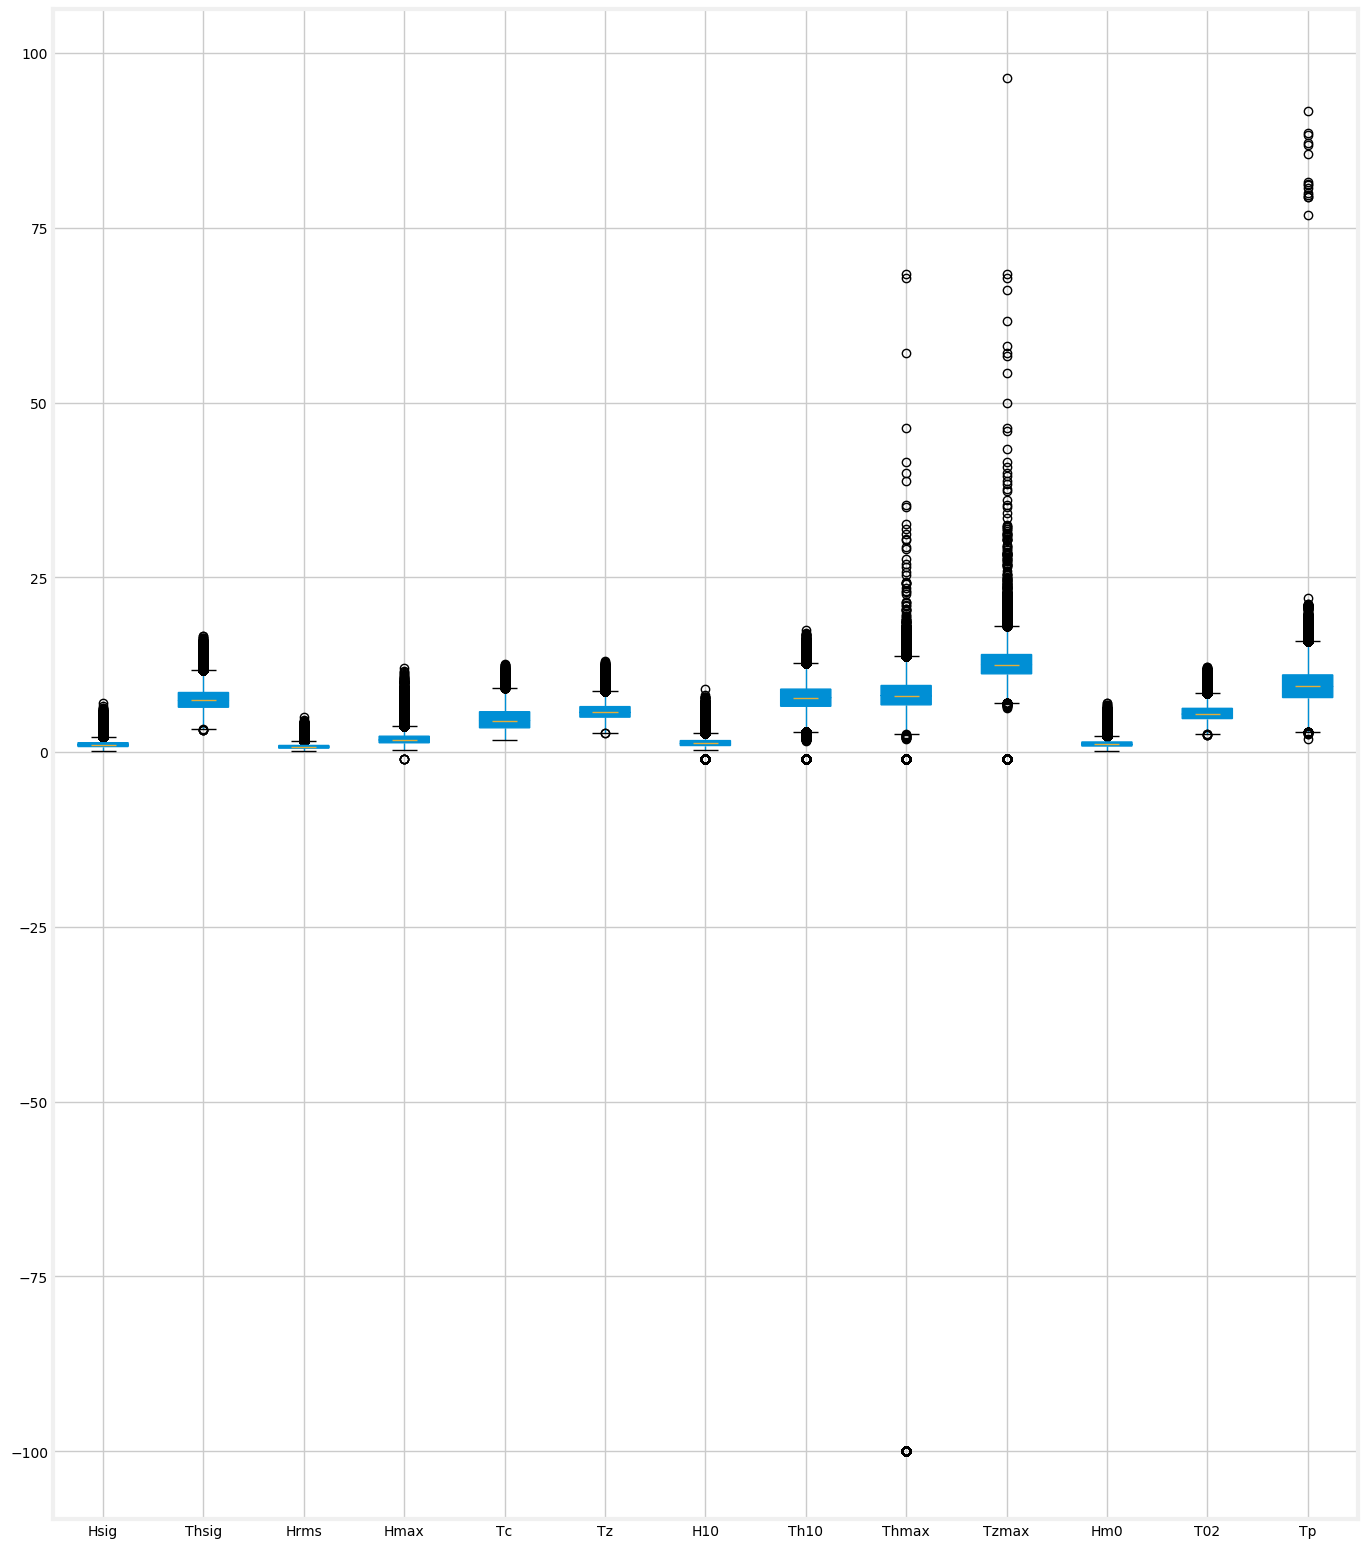

In [4]:
# Do Box Plot of extremes for each parameter and display their details
plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(15,20),dpi=100)
recs.boxplot(column=['Hsig','Thsig','Hrms','Hmax','Tc','Tz','H10','Th10','Thmax','Tzmax','Hm0','T02','Tp'],notch=True,patch_artist=True)

details = recs.describe()
details

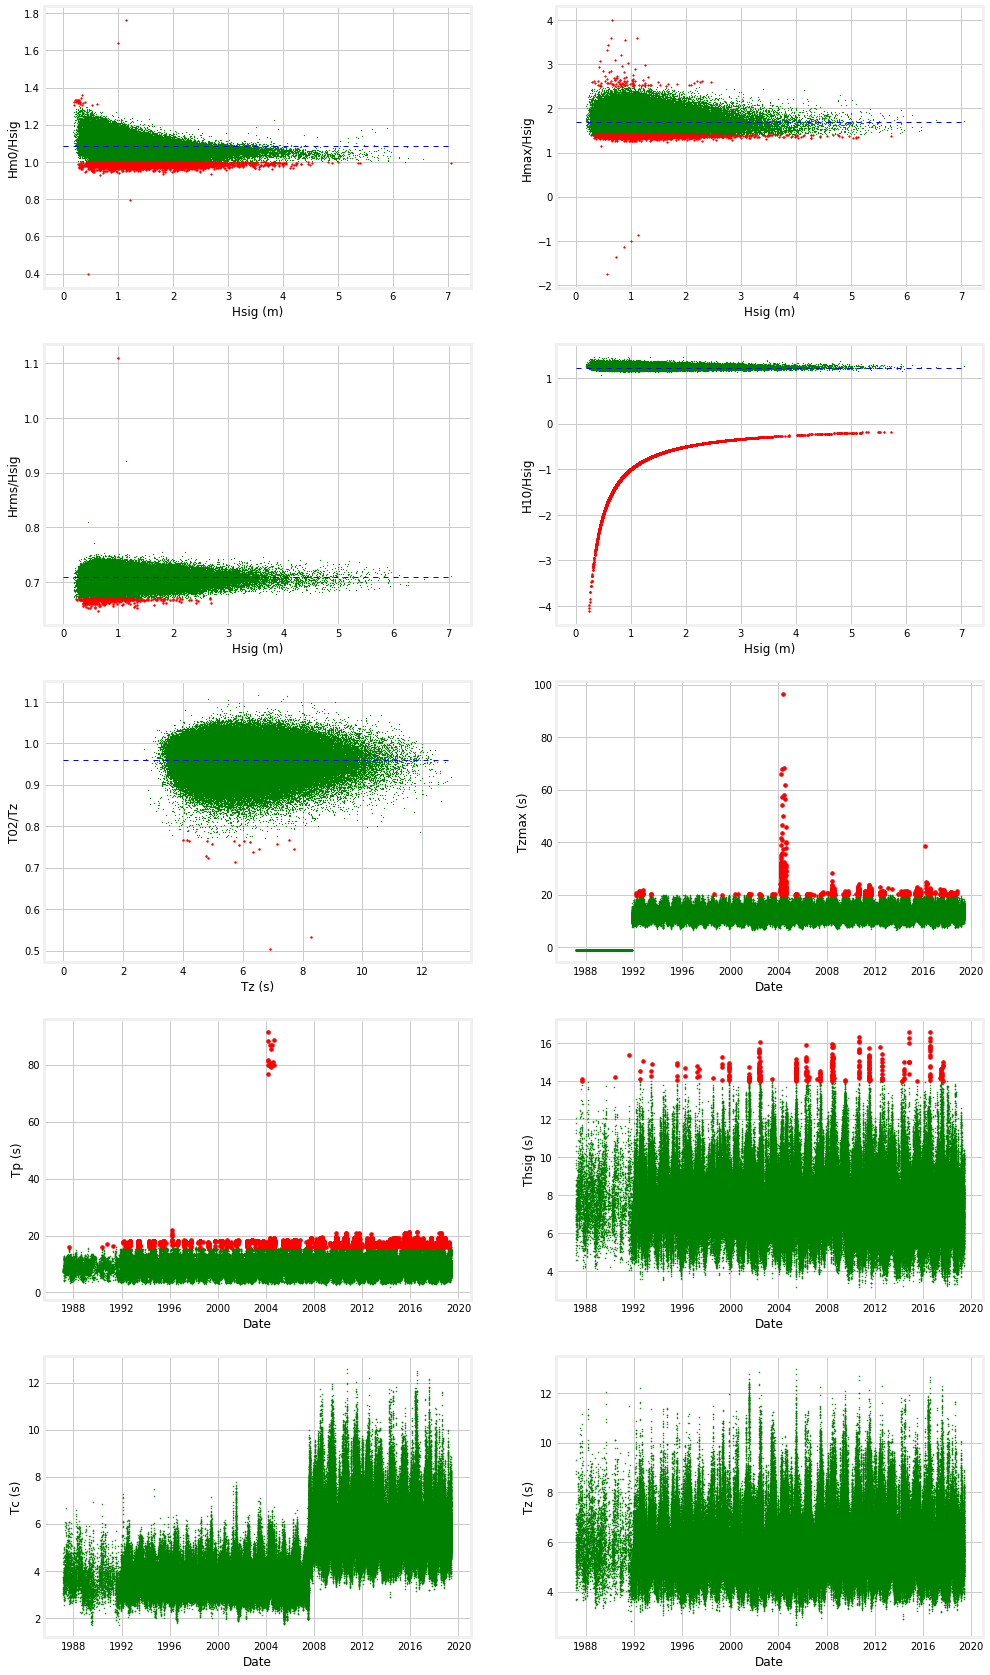

In [5]:
details = recs.describe()
plt.rcParams['axes.facecolor'] = 'white'
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,30), facecolor=(1, 1, 1))

ax1.scatter(recs.Hsig,recs.Hm0/recs.Hsig,s=0.5,c='g')
suspect_Hm0_Hsig = recs[~(recs.Hm0/recs.Hsig).between(1.0,1.3,inclusive=False)]
ax1.scatter(suspect_Hm0_Hsig.Hsig,suspect_Hm0_Hsig.Hm0/suspect_Hm0_Hsig.Hsig,s=2.5,c='r')
mode = details.Hm0[5]/details.Hsig[5]
ax1.plot([0,max(recs.Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax1.set_xlabel("Hsig (m)")
ax1.set_ylabel("Hm0/Hsig")

ax2.scatter(recs.Hsig,recs.Hmax/recs.Hsig,s=0.5,c='g')
suspect_Hmax_Hsig = recs[~(recs.Hmax/recs.Hsig).between(1.4,2.5,inclusive=False)]
ax2.scatter(suspect_Hmax_Hsig.Hsig,suspect_Hmax_Hsig.Hmax/suspect_Hmax_Hsig.Hsig,s=2.5,c='r')
mode = details.Hmax[5]/details.Hsig[5]
ax2.plot([0,max(recs.Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax2.set_xlabel("Hsig (m)")
ax2.set_ylabel("Hmax/Hsig")

ax3.scatter(recs.Hsig,recs.Hrms/recs.Hsig,s=0.5,c='g')
suspect_Hrms_Hsig = recs[~(recs.Hrms/recs.Hsig).between(0.67,0.95,inclusive=False)]
ax3.scatter(suspect_Hrms_Hsig.Hsig,suspect_Hrms_Hsig.Hrms/suspect_Hrms_Hsig.Hsig,s=3.5,c='r')
mode = details.Hrms[5]/details.Hsig[5]
ax3.plot([0,max(recs.Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax3.set_xlabel("Hsig (m)")
ax3.set_ylabel("Hrms/Hsig")

ax4.scatter(recs.Hsig,recs.H10/recs.Hsig,s=0.5,c='g')
suspect_H10_Hsig = recs[~(recs.H10/recs.Hsig).between(1.0,1.6,inclusive=False)]
ax4.scatter(suspect_H10_Hsig.Hsig,suspect_H10_Hsig.H10/suspect_H10_Hsig.Hsig,s=3.5,c='r')
mode = details.H10[5]/details.Hsig[5]
ax4.plot([0,max(recs.Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax4.set_xlabel("Hsig (m)")
ax4.set_ylabel("H10/Hsig")

ax5.scatter(recs.Tz,recs.T02/recs.Tz,s=0.5,c='g')
suspect_Tz_T02 = recs[~(recs.Tz/recs.T02).between(0.8,1.3,inclusive=False)]
ax5.scatter(suspect_Tz_T02.Tz,suspect_Tz_T02.T02/suspect_Tz_T02.Tz,s=3.5,c='r')
mode = details.T02[5]/details.Tz[5]
ax5.plot([0,max(recs.Tz)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax5.set_xlabel("Tz (s)")
ax5.set_ylabel("T02/Tz")

ax6.plot(recs.Tzmax,lw=0,marker='o',ms=0.5,c='g')
suspect_Tzmax = recs[(recs.Tzmax).gt(20)]
ax6.plot(suspect_Tzmax.Tzmax,lw=0,marker='o',ms=3.5,c='r')
ax6.set_xlabel("Date")
ax6.set_ylabel("Tzmax (s)")

ax7.plot(recs.Tp,lw=0,marker='o',ms=0.5,c='g')
suspect_Tp = recs[~(recs.Tp).between(1,16,inclusive=False)]
ax7.plot(suspect_Tp.Tp,lw=0,marker='o',ms=3.5,c='r')
ax7.set_xlabel("Date")
ax7.set_ylabel("Tp (s)")

ax8.plot(recs.Thsig,lw=0,marker='o',ms=0.5,c='g')
suspect_Thsig = recs[(recs.Thsig).gt(14)]
ax8.plot(suspect_Thsig.Thsig,lw=0,marker='o',ms=3.5,c='r')
ax8.set_xlabel("Date")
ax8.set_ylabel("Thsig (s)")

ax9.plot(recs.Tc,lw=0,marker='o',ms=0.5,c='g')
suspect_Tc = recs[(recs.Tc).gt(14)]
ax9.plot(suspect_Tc.Tc,lw=0,marker='o',ms=3.5,c='r')
ax9.set_xlabel("Date")
ax9.set_ylabel("Tc (s)")

ax10.plot(recs.Tz,lw=0,marker='o',ms=0.5,c='g')
suspect_Tz = recs[(recs.Tz).gt(14)]
ax10.plot(suspect_Tz.Tz,lw=0,marker='o',ms=3.5,c='r')
ax10.set_xlabel("Date")
ax10.set_ylabel("Tz (s)")

plt.show()

In [58]:
pd.set_option('mode.chained_assignment', None)

# add ratio column to DF and sort it in descending order of the ratio
suspect_Hm0_Hsig['Ratio'] = suspect_Hm0_Hsig.apply(lambda row: row.Hm0/row.Hsig, axis=1)
suspect_Hm0_Hsig = suspect_Hm0_Hsig.sort_values(['Ratio'], ascending=[False])

plt.figure(figsize=(10,10),dpi=100)
plt.scatter(suspect_Hm0_Hsig.Hsig,suspect_Hm0_Hsig.Hm0/suspect_Hm0_Hsig.Hsig,s=2.5,c='r')
plt.xlabel("Hsig (m)")
plt.ylabel("Hm0/Hsig")

In [67]:
len(suspect_Hm0_Hsig)

6581

Text(0, 0.5, 'Tc (s)')

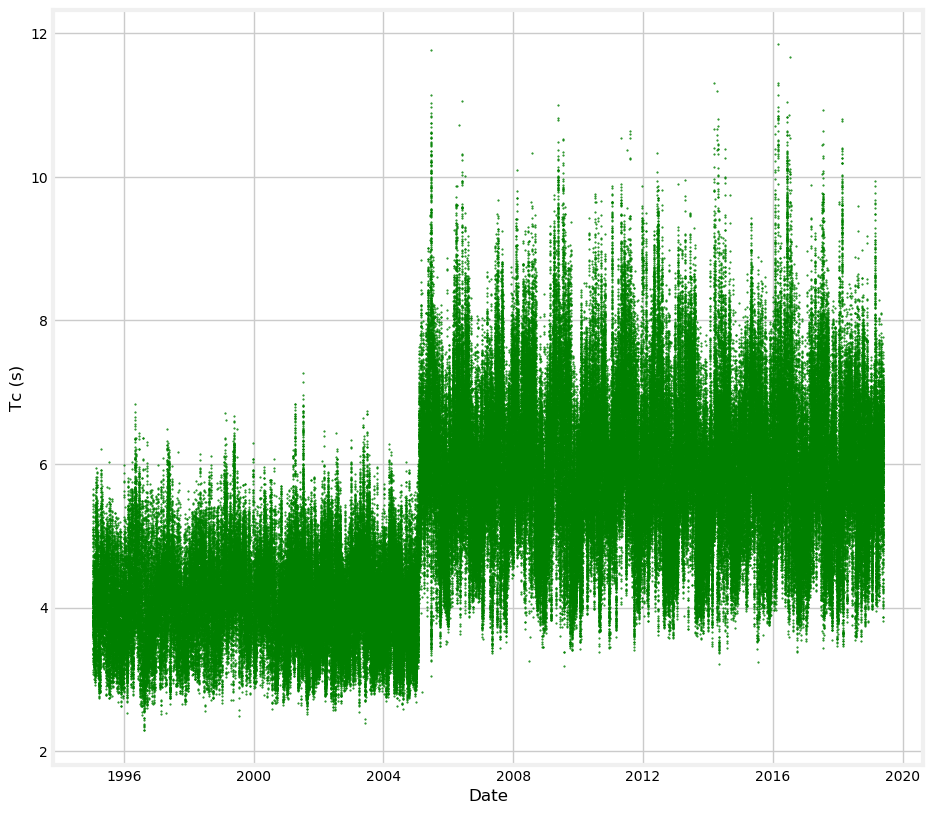

In [5]:
# Do scatter plot of Master file Tc v's RTWS Tc
plt.figure(figsize=(10,10),dpi=100)
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(recs.Tc,lw=0,marker='o',ms=0.5,c='g')
suspect_Tc = recs[(recs.Tc).gt(14)]
plt.plot(suspect_Tc.Tc,lw=0,marker='o',ms=3.5,c='r')
plt.xlabel("Date")
plt.ylabel("Tc (s)")